# Base para Todas Versões

## Instalações

In [ ]:
!pip install tensordict
!pip install torchrl

In [55]:
# !pip install --upgrade torch torchvision

In [56]:
# !pip install av

## Importações

In [57]:
import numpy as np
import torch
import time
import torchvision
from torchrl.envs import GymEnv, StepCounter, TransformedEnv
from torchrl.modules import EGreedyModule, MLP, QValueModule
from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyTensorStorage,ListStorage, ReplayBuffer, PrioritizedReplayBuffer
from torchrl.objectives import DQNLoss, SoftUpdate
from torchrl._utils import logger as torchrl_logger
from torchrl.record import CSVLogger, VideoRecorder
from tensordict.nn import TensorDictModule as Mod, TensorDictSequential as Seq
from torch.optim import Adam
from torchrl.data.replay_buffers.samplers import PrioritizedSampler

import matplotlib.pyplot as plt

import os
from IPython.display import Audio, display
from collections import deque

In [58]:
# import torch

# torch.manual_seed(0)

# import time

# from torchrl.envs import GymEnv, StepCounter, TransformedEnv

# env = TransformedEnv(GymEnv("CartPole-v1"), StepCounter())
# env.set_seed(0)

# from tensordict.nn import TensorDictModule as Mod, TensorDictSequential as Seq

In [59]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')   # Monta o Google Drive

## Parâmetros Gerais

In [60]:
nome_jogo = "CartPole-v1"     # Define o nome do ambiente de RL a ser utilizado.
num_celulas = [64, 64]        # Define a arquitetura da rede neural, com duas camadas ocultas de 64 neurônios cada.
passos_decaimento = 345       # Número de passos até o valor mínimo de epsilon
epsilon_ini = 1               # Valor inicial de epsilon
epsilon_fim = 0.001           # Valor mínimo de epsilon
passos_aleatorios_ini = 500   # Define o número inicial de passos aleatórios a serem realizados no ambiente antes de começar a usar a política treinada.
exp_coletadas = 500           # Define o número de frames (ou passos de tempo) que serão coletados em cada lote (batch) de coleta de dados do ambiente.
passos_otimizacao = 10        # Define o número de passos de otimização que serão realizados após cada lote de coleta de dados.
tamanho_buffer = 100000       # Define o tamanho do buffer de replay.
alfa = 0.6                    # Parâmetro de correção de viés de importância. Valores maiores de beta aumentam a correção.
beta = 1.0                    # O parâmetro de correção de viés de importância. Valores maiores de beta aumentam a correção.
funcao_perda = "l2"           # Pode ser “l1”, “l2” ou “smooth_l1”.
valor_delay = True            # O padrão é False para não criar uma rede alvo.
taxa_aprendizado = 0.001      # Define a taxa de aprendizado (learning rate) para o otimizador.
tau = 0.99                    # Define o fator de atualização suave da rede alvo para a política de exploração.
renderizado_pixel = True      # Indica que o ambiente será renderizado a partir de pixels, permitindo a gravação visual do ambiente.
somente_pixel = False         # Tanto as observações em forma de pixels quanto outras observações (como a posição e a velocidade do carrinho) serão retornadas pelo ambiente.
caminho = "./training_loop"   # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
formato_video = "mp4"         # Especifica o formato de vídeo para gravação.
episodios = 15000              # Define o número total de episódios a serem treinados.
quantidade_paradas = 5        # Número de paradas em 500 pontos
tamanho_amostra = 500         # Tamanho dO MINIBATCH
passos_maximo = 500           # Número máximo de passos para cada episódio.
recompensa_maxima = 500       # Define a recompensa máxima que o agente pode receber.

In [61]:
nome_pasta_1 = "_" + nome_jogo + "_RN-" + str(num_celulas[0])+"-"+str(num_celulas[1])+"_EG-"+str(passos_decaimento)+"-"+str(epsilon_ini)+"-"+str(epsilon_fim)
nome_pasta_2 = '_CD-' + str(passos_aleatorios_ini) + '-' + str(exp_coletadas) + '-' + str(passos_otimizacao)
nome_pasta_3 = '_RB-' + str(tamanho_buffer/1000) + 'k-' + str(alfa) + '-' + str(beta)
nome_pasta_4 = '_O-' + str(funcao_perda) + '-' + str(taxa_aprendizado) + '_AR-' + str(tau)
nome_pasta_5 = '_T-' + str(episodios/1000) + 'k-' + str(quantidade_paradas) + '-' + str(tamanho_amostra)
nome_pasta = nome_pasta_1 + nome_pasta_2 + nome_pasta_3 + nome_pasta_4 + nome_pasta_5
print(nome_pasta)

_CartPole-v1_RN-64-64_EG-345-1-0.001_CD-500-500-10_RB-100.0k-0.6-1.0_O-l2-0.001_AR-0.99_T-15.0k-5-500


## Construindo o ambiente

Estaremos usando um ambiente de academia com uma StepCounter transformação. Se precisar de uma atualização, verifique se esses recursos são apresentados no tutorial do ambiente .

In [62]:
def criar_ambiente(nome_jogo, semente = 0):
    torch.manual_seed(semente) # define a semente manual para a geração de números aleatórios no PyTorch, garantindo a reprodutibilidade dos resultados.
    env = TransformedEnv(GymEnv(nome_jogo), StepCounter()) # cria o ambiente "CartPole-v1" do OpenAI Gym, com um contador de passos adicionado
    env.set_seed(semente) # define a semente para o ambiente env, garantindo a consistência do comportamento do ambiente em diferentes execuções.
    return env

## Projetando uma política

O próximo passo é construir nossa política. Faremos uma versão regular e determinística do ator para ser usada no módulo de perda e durante a avaliação . A seguir, iremos aumentá-lo com um módulo de exploração para inferência .

### Rede Neural

In [63]:
def criar_rede_neural(ambiente, num_celulas):
    # Cria uma MLP que mapeia observações do ambiente para valores de ação, com duas camadas ocultas de 64 neurônios cada.
    value_mlp = MLP(out_features = ambiente.action_spec.shape[-1], num_cells = num_celulas)

    # Cria um módulo que pega as observações do ambiente (observation) e produz valores de ação (action_value) usando a MLP definida anteriormente.
    value_net = Mod(value_mlp, in_keys = ["observation"], out_keys = ["action_value"])
    return value_net

### Política e Política de Exploração

In [64]:
def criar_politica(ambiente, rede_valor, passos_decaimento, epsilon_ini, epsilon_fim):
    # Cria política que primeiro passa a observação através da value_net para obter os valores de ação
    # e, em seguida, usa o QValueModule para calcular os valores Q para as ações.
    policy = Seq(rede_valor, QValueModule(spec = ambiente.action_spec))

    # Cria um módulo de exploração que implementa uma estratégia epsilon-greedy com um valor inicial de epsilon de 0.5 e que diminui ao longo de 100.000 passos.
    exploration_module = EGreedyModule(ambiente.action_spec, annealing_num_steps = passos_decaimento, eps_init = epsilon_ini, eps_end = epsilon_fim)

    # Combina a política com o módulo de exploração em uma sequência, resultando em uma política que primeiro calcula os valores de ação
    # e, em seguida, aplica a estratégia epsilon-greedy para selecionar as ações.
    policy_explore = Seq(policy, exploration_module)  # Seq: Refere-se ao TensorDictSequential.

    return policy, exploration_module, policy_explore

Passando de e- decay = 0,98 para propocional em passos:

\begin{align}
 ϵ_{\mbox{inicial}} * ϵ_{\mbox{decay}}^{n_p} = ϵ_{\mbox{mínimo}}
\end{align}

\begin{align}
 n_p = (\frac{\log ϵ_{\mbox{mínimo}} - \log ϵ_{\mbox{inicial}} }{\log ϵ_{\mbox{decay}}})
\end{align}

\begin{align}
 n_p ≈ 345
\end{align}



## Coletor de Dados

In [65]:
def criar_coletor(ambiente, politica, exp_coletadas, passos_aleatorios_ini, exp_totais = -1):
    # Um coletor de dados síncrono que coleta experiências do ambiente usando a política fornecida.
    collector = SyncDataCollector(
    ambiente,                                     # O ambiente de RL, criado anteriormente com TransformedEnv.
    politica,                                     # A política usada para coletar experiências do ambiente.
    frames_per_batch = exp_coletadas,             # Especifica que 200 frames serão coletados em cada lote.
    total_frames = exp_totais,                    # Especifica que o coletor deve continuar indefinidamente (ou até que seja explicitamente parado).
    init_random_frames = passos_aleatorios_ini,   # init_random_frames=init_rand_steps: 5000 passos aleatórios realizados inicialmente p/ preencher o rb.
    )
    return collector

## Buffer de Replay

In [66]:
def criar_Buffer_Replay(tamanho_buffer, tipo_armazenamento = LazyTensorStorage):
    rb = ReplayBuffer(storage = tipo_armazenamento(tamanho_buffer)) # Buffer de replay usado p/ armazenar experiências anteriores p/ amostragem durante o treinamento.
    return rb

In [67]:
def criar_Buffer_Replay_Amostra_PER(tamanho_buffer, alfa, b, tipo_armazenamento = LazyTensorStorage):
    rb = ReplayBuffer(storage = tipo_armazenamento(tamanho_buffer),
                      sampler = PrioritizedSampler(max_capacity = tamanho_buffer,            # A capacidade máxima do amostrador, que deve ser consistente com o tamanho do buffer de replay.
                                                   alpha = alfa,                             # Controla quão fortemente a prioridade afeta a amostragem. Valores maiores de @: amostragem dependa mais das prioridades.
                                                   beta = b))                                # O parâmetro de correção de viés de importância. Valores maiores de beta aumentam a correção.
    return rb

In [68]:
def criar_Buffer_Replay_PER(tamanho_buffer, alfa, b, tipo_armazenamento = LazyTensorStorage):
    rb = PrioritizedReplayBuffer(alpha = alfa, beta = b, storage = tipo_armazenamento(tamanho_buffer))
    return rb

## Módulo de Perda

In [69]:
def criar_perda(politica, ambiente, funcao_perda, reducao, valor_delay = True):
    #  Implementa a função de perda para o algoritmo DQN (Deep Q-Network).
    loss = DQNLoss(value_network = politica, action_space = ambiente.action_spec, loss_function = funcao_perda, delay_value = valor_delay, reduction = reducao)
    return loss

## Otimizador

In [70]:
def criar_otimizador(perca, taxa_aprendizado):
    # Um otimizador amplamente utilizado que combina as vantagens dos métodos AdaGrad e RMSProp.
    optim = Adam(perca.parameters(), lr = taxa_aprendizado)
    return optim

## Atualização da Rede Alvo

In [71]:
def criar_atualizador_rede_alvo(perca, tau):
    # Implementa a atualização suave dos parâmetros da rede, uma técnica comum em algoritmos de RL para atualizar gradualmente uma rede alvo (target network) com os parâmetros da rede de valor (online network).
    updater = SoftUpdate(perca, eps = tau)
    return updater

## Registrador

In [72]:
def criar_registrador(nome_experiencia, caminho, formato_video, etiqueta, nome_jogo, renderizado_pixel = True, somente_pixel = False):
    # CSVLogger: Um logger que registra dados em formato CSV, útil para monitorar o progresso do treinamento e analisar resultados.
    logger = CSVLogger(exp_name = nome_experiencia, log_dir = caminho, video_format = formato_video)

    # Um objeto que grava vídeos das execuções do ambiente durante o treinamento, útil para visualizar o comportamento do agente.
    video_recorder = VideoRecorder(logger, tag = etiqueta)

    # Um wrapper que aplica transformações ao ambiente, como normalização de observações ou recompensas, e também permite a adição de funcionalidades como gravação de vídeos.
    record_env = TransformedEnv(GymEnv(nome_jogo, from_pixels = renderizado_pixel, pixels_only = somente_pixel), video_recorder)
    return logger, video_recorder, record_env

## Funções Auxiliares

### Plotagem

In [73]:
def plotar(dados,
           xlabel = 'Episódio',
           ylabel = 'Recompensa',
           limit = True,
           xlimit = 1000,
           ylimit = 1000,
           title = 'Desempenho do Agente'):

    plt.plot(dados)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if limit:
      xlimit = [0,(xlimit*1.05)]
      ylimit = [0,(ylimit*1.05)]
      plt.xlim(xlimit)
      plt.ylim(ylimit)

    plt.title(title)
    plt.show()

In [74]:
def plotar_versoes(
                  #  dados,
                   coluna = 'Rewards_ep',
                   xlabel = 'Episódio',
                   ylabel = 'Recompensa',
                   tamanho_fig = (10, 6),
                   limit = True,
                   xlimit = 1000,
                   ylimit = 1000,
                   title = 'Desempenho do Agente'):
    plt.figure(figsize=tamanho_fig)

    plt.plot(resultado_medio_V1[coluna],          label = "V1 (DQN)")
    plt.plot(resultado_medio_V2_rb[coluna] ,      label = "V2 (ReplayBuffer)")
    plt.plot(resultado_medio_V2_prb[coluna] ,     label = "V2 (PrioritazedReplayBuffer)")
    plt.plot(resultado_medio_V2_1[coluna] ,       label = "V2.1 (PER Média Amostral)")
    plt.plot(resultado_medio_V2_2[coluna] ,       label = "V2.2 (PER Soma Amostral)")
    plt.plot(resultado_medio_V3_1v[coluna] ,      label = "V3 (PER Últimos Índices - Priorização 1ª Vez)")
    plt.plot(resultado_medio_V3_2v[coluna] ,      label = "V3 (PER Últimos Índices - Priorização 2ª Vez)")
    plt.plot(resultado_medio_V3_1[coluna] ,       label = "V3.1 (PER Melhores Índices - Max)")
    plt.plot(resultado_medio_V3_2_sm1[coluna] ,   label = "V3.2 (PER Melhores Índices - Semi-Trajetória 1)")
    plt.plot(resultado_medio_V3_2_sm2[coluna] ,   label = "V3.2 (PER Melhores Índices - Semi-Trajetória 2)")
    plt.plot(resultado_medio_V3_3[coluna] ,       label = "V3.3 (PER Piores Índices - Max)")
    plt.plot(resultado_medio_V3_4_sm1[coluna] ,   label = "V3.4 (PER Piores Índices - Semi-Trajetória 1)")
    plt.plot(resultado_medio_V3_4_sm2[coluna] ,   label = "V3.4 (PER Piores Índices - Semi-Trajetória 2)")
    plt.plot(resultado_medio_V4[coluna] ,         label = "V4 (PER Última Trajetória)")
    plt.plot(resultado_medio_V4_1[coluna] ,       label = "V4.1 (PER Melhores Trajetórias)")
    plt.plot(resultado_medio_V4_2[coluna] ,       label = "V4.2 (PER Fortalecimento da Base)")
    plt.plot(resultado_medio_V4_3[coluna] ,       label = "V4.3 (PER Piores Trajetórias)")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    # plt.legend(bbox_to_anchor=(0.08, -0.18, 0.9, .102), loc = 'center', ncols = 3, mode = "expand", borderaxespad = 0.)

    # plt.plot(dados)

    if limit:
      xlimit = [0, (xlimit * 1.05)]
      ylimit = [0, (ylimit * 1.05)]
      plt.xlim(xlimit)
      plt.ylim(ylimit)

    plt.title(title)
    plt.show()

### Aviso de Conclusão

In [75]:
def play_sound(tempo, nota = 0):
    # Cria um som (um simples tom sinusoidal)
    framerate = 44100               # Taxa de amostragem
    duration = tempo + 1            # Duração em segundos

    if nota == 1:
        frequency = 261.625519            # Frequência do som em Hz (C3)
    elif nota == 2:
        frequency = 277.182648            # Frequência do som em Hz (C#3)
    elif nota == 3:
        frequency = 293.664734            # Frequência do som em Hz (D3)
    elif nota == 4:
        frequency = 311.126984            # Frequência do som em Hz (D#3)
    elif nota == 5:
        frequency = 329.627533            # Frequência do som em Hz (E3)
    elif nota == 6:
        frequency = 349.228241            # Frequência do som em Hz (F3)
    elif nota == 7:
        frequency = 369.994385            # Frequência do som em Hz (F#3)
    elif nota == 8:
        frequency = 391.995392            # Frequência do som em Hz (G3)
    elif nota == 9:
        frequency = 415.304688            # Frequência do som em Hz (G#3)
    elif nota == 10:
        frequency = 440.0                 # Frequência do som em Hz (A3)
    elif nota == 11:
        frequency = 466.163761            # Frequência do som em Hz (A#3)
    else:
        frequency = 493.883301            # Frequência do som em Hz (B3)

    t = np.linspace(0, duration, int(framerate * duration))
    data = np.sin(2 * np.pi * frequency * t)

    # Toca o som
    display(Audio(data, rate=framerate, autoplay=True))

In [76]:
# # Exemplo de simulação (substitua esta parte pelo seu código de simulação)
# print("Iniciando simulação...")
# time.sleep(5)  # Simula um processo que leva tempo para terminar
# print("Simulação concluída!")

# # Toca o som quando a simulação termina
# play_sound(1)

### Salvar e Carregar Dados em Excel

In [77]:
def salvar_array(score_list_1,
                 score_list_mean_100,
                 eval_score,
                 mean_100_eval_score,
                 eval_score_mean,
                 Sucessos,
                 Desempenho_Medio,
                 cenario="C1",
                 versao="V1",
                 numero_simulacao = 1,
                 caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                 pasta = "teste"):

    recomp_ep = np.array(score_list_1)#.reshape(-1, 1)
    recomp_med_ep = np.array(score_list_mean_100)#.reshape(-1, 1)
    recomp_ep_eval = np.array(eval_score)#.reshape(-1, 1)
    recomp_med_ep_eval = np.array(mean_100_eval_score)#.reshape(-1, 1)
    recomp_med_eval_ep = np.array(eval_score_mean).reshape(1, )
    sucess_rates = np.array(Sucessos)#.reshape(-1, 1)
    taxa_med_eval_ep = np.array(Desempenho_Medio).reshape(1, )


    array_coluna1 = recomp_ep
    array_coluna2 = recomp_med_ep
    array_coluna3 = recomp_ep_eval
    array_coluna4 = recomp_med_ep_eval
    array_coluna5 = sucess_rates
    array_coluna6 = recomp_med_eval_ep
    array_coluna7 = taxa_med_eval_ep


    # Preenchendo os arrays com tamanhos diferentes para que tenham o mesmo tamanho
    tamanho_maximo = max(len(array_coluna1),
                         len(array_coluna2),
                         len(array_coluna3),
                         len(array_coluna4),
                         len(array_coluna5),
                         len(array_coluna6),
                         len(array_coluna7))
    array_coluna1 = np.pad(array_coluna1, (0, tamanho_maximo - len(array_coluna1)), mode='constant', constant_values=-9999)
    array_coluna2 = np.pad(array_coluna2, (0, tamanho_maximo - len(array_coluna2)), mode='constant', constant_values=-9999)
    array_coluna3 = np.pad(array_coluna3, (0, tamanho_maximo - len(array_coluna3)), mode='constant', constant_values=-9999)
    array_coluna4 = np.pad(array_coluna4, (0, tamanho_maximo - len(array_coluna4)), mode='constant', constant_values=-9999)
    array_coluna5 = np.pad(array_coluna5, (0, tamanho_maximo - len(array_coluna5)), mode='constant', constant_values=-9999)
    array_coluna6 = np.pad(array_coluna6, (0, tamanho_maximo - len(array_coluna6)), mode='constant', constant_values=-9999)
    array_coluna7 = np.pad(array_coluna7, (0, tamanho_maximo - len(array_coluna7)), mode='constant', constant_values=-9999)

    # Criando o DataFrame com os arrays de colunas
    df = pd.DataFrame({'Rewards_ep': array_coluna1,
                        'Rewards_mean_ep': array_coluna2,
                        'Rewards_ep_eval': array_coluna3,
                        'Rewards_mean_ep_eval': array_coluna4,
                        'Sucess_Rates': array_coluna5,
                        'Mean_Rewards_ep_eval': array_coluna6,
                        'Mean_Sucess_Rates': array_coluna7})

    # Substituindo os valores de preenchimento por None
    df = df.replace(-9999, None)

    # Salvando o DataFrame em uma planilha Excel'
    nome_da_pasta = str(cenario) + pasta
    caminho_pasta =  caminho + nome_da_pasta  # Define o caminho da pasta no Google Drive
    if not os.path.exists(caminho_pasta): os.makedirs(caminho_pasta) # Cria a pasta se ela não existir
    nome_arquivo = '/Resultado_de_'+ str(versao)+'_simu_'+ str(numero_simulacao)  +'.xlsx'
    caminho_completo =  caminho_pasta + nome_arquivo
    # caminho_completo = os.path.join(caminho_pasta, nome_arquivo)

    df.to_excel(caminho_completo, index=False)

    print("DataFrame salvo em", caminho_completo)
    play_sound(5, numero_simulacao)
    return caminho_completo

In [78]:
def carrega_array(cenario,
                  versao,
                  numero_simulacao = 1,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = "teste"):
    # Substitua o caminho do arquivo pelo caminho real no seu Google Drive
    # caminho_do_arquivo = '/content/drive/My Drive/CBA 2024/Resultados//Result_of_Epoch_'+ str(epoch) + '_' + str(versao) +'.xlsx'
    # nome_arquivo = '/Result_of_Epoch_'+ str(epoch) + '_' + str(versao) +'.xlsx'
    caminho_pasta =  caminho + str(cenario) + pasta + '/'
    nome_arquivo = '/Resultado_de_'+ str(versao)+'_simu_'+ str(numero_simulacao)  +'.xlsx'
    caminho_completo = caminho_pasta + nome_arquivo

    # Carregue a planilha usando o pandas
    # df = pd.read_excel(caminho_do_arquivo)
    df = pd.ExcelFile(caminho_completo)
    # acoes = df.parse('Ações (A)')
    # resultado = df.parse()
    resultado = df.parse('Sheet1')
    # empresa = np.array(acoes.Empresas)

    # Exiba o DataFrame para verificar se a leitura foi bem-sucedida
    # acoes.head()
    # resultado.head()

    # # Plotagem
    # # from matplotlib import pyplot as plt
    # plt.figure()
    # # plt.subplot(1, 2, 1)  # Subplot 1
    # resultado['Rewards_ep'].plot(kind='line', figsize=(8, 4), title='Rewards_ep_train')
    # plt.gca().spines[['top', 'right']].set_visible(False)

    # plt.figure()
    # # plt.subplot(1, 2, 1)  # Subplot 1
    # resultado['Rewards_ep_eval'].plot(kind='line', figsize=(8, 4), title='Rewards_ep_eval')
    # plt.gca().spines[['top', 'right']].set_visible(False)


    # # from matplotlib import pyplot as plt
    # plt.figure()
    # # plt.subplot(1, 2, 2)  # Subplot 2
    # resultado['Sucess_Rates'].plot(kind='line', figsize=(8, 4), title='Sucess_Rates')
    # plt.gca().spines[['top', 'right']].set_visible(False)

    return resultado

In [79]:
def carrega_varios(cenario, versao, inicio = 1, fim = 10, caminho = '/content/drive/My Drive/CBA 2024/Resultados/', pasta = "teste"):
    resultado = []

    for i in range(inicio, (fim+1)):
      resultado.append(carrega_array(cenario = str(cenario), versao = str(versao), numero_simulacao = i, caminho = caminho, pasta = pasta ))

    return resultado

In [80]:
def carrega_media_versoes(cenario,
                          versao=["V1", "V2_rb", "V2_prb", "V2.1", "V2.2"],
                          inicio = 1,
                          fim = 10,
                          caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                          pasta = "teste"):
    resultado_versoes = []
    # resultado_medio = None

    for i in versao:
      resultado = carrega_varios(cenario = str(cenario), versao = str(i), inicio = inicio, fim = fim, caminho = caminho, pasta = pasta)
      resultado_med = resultado_medio(resultado)
      resultado_versoes.append(resultado_med)

    resultado_medio_V1 = resultado_versoes[0]
    resultado_medio_V2_rb = resultado_versoes[1]
    resultado_medio_V2_prb = resultado_versoes[2]
    resultado_medio_V2_1 = resultado_versoes[3]
    resultado_medio_V2_2 = resultado_versoes[4]

    return resultado_medio_V1, resultado_medio_V2_rb, resultado_medio_V2_prb, resultado_medio_V2_1, resultado_medio_V2_2

### Avaliação

In [81]:
def avaliar(env, policy, max_steps=500):
    eval_score = []
    mean_100_eval_score = []

    for i in range(1001):
        eval_score.append(env.rollout(max_steps, policy)["next","step_count"][-1].item())
        if (i%100)==0:
          if i!=0:
            mean_100_eval_score.append(np.mean(eval_score[-100]))

    eval_score_mean = np.mean(mean_100_eval_score)
    # print(f"Mean 100 eval score: {eval_score_mean}")

    # plt.plot(mean_100_eval_score)
    # plt.show()

    return eval_score, mean_100_eval_score, eval_score_mean

In [82]:
def taxa_sucesso(mean_100_eval_score):
    Sucessos = [0]

    for i in mean_100_eval_score:
      bb = (i/500)*100
      Sucessos.append(bb)

    Desempenho_Medio = np.mean(Sucessos[-10])
    print(f"Desempenho Medio: {Desempenho_Medio}")

    plt.plot(Sucessos)
    plt.ylim(0,100)
    plt.show()

    return Sucessos, Desempenho_Medio

### Cálculo de Resultados Médios

In [83]:
def resultado_medio(resultado):
    soma_resultado = 0

    for i in resultado:
        soma_resultado += i

    resultado_medio = soma_resultado/(len(resultado))

    return resultado_medio

# V1: DQN

## Parâmetros da Versão

In [84]:
reducao = "mean"              # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V1"   # Define o nome da experiência.
etiqueta = "video_V1"         # Uma tag para identificar os vídeos nos logs.

## Classe Agente V1

In [85]:
class Mod_Agente_V1:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta, funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.rb = criar_Buffer_Replay(self.tamanho_buffer)
        self.funcao_perda = funcao_perda
        self.reducao = reducao             # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):

            for passo_atual in dado["next","step_count"]:
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

            self.rb.extend(dado)                                     # Grava dados no buffer de repetição
            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay, acessando o campo "step_count".

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra = self.rb.sample(self.tamanho_amostra)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                              # Atualiza o contador total de passos coletados.
            self.total_episodios += dado["next", "done"].sum()             # Atualiza o contador total de episódios completados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")

            ### Condição de Parada
            if self.total_episodios >= self.episodios:
                break

        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [86]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V1 = Mod_Agente_V1(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                              tamanho_buffer, alfa, beta, funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V1.treinar_agente(episodios, tamanho_amostra)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V1.ambiente, agente_V1.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V1",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

## Carrega e Exibe Resultados

In [ ]:
# resultado_1_V1 = carrega_array("C1",
#                   "V1",
#                   numero_simulacao = 1,
#                   caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
#                   pasta = nome_pasta)
# resultado_1_V1.head()

In [ ]:
# resultado = carrega_varios("C1",
#                            "V1",
#                            inicio=11,
#                            fim=20,
#                            caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
#                            pasta = nome_pasta)
# resultado[0].head()

In [ ]:
# resultado_medio_V1 = resultado_medio(resultado)

In [ ]:
# plotar(resultado_medio_V1['Rewards_ep'],
#        xlabel = 'Episódios',
#        ylabel = 'Recompensa Total',
#        limit = True,
#        xlimit = episodios,
#        ylimit = 500,
#        title = 'Média dos Desempenhos por Episódio nos Treinamentos')

In [ ]:
# plotar(resultado_medio_V1['Rewards_mean_ep'],
#        xlabel = 'Episódios',
#        ylabel = 'Recompensa Total',
#        limit = True,
#        xlimit = episodios,
#        ylimit = 500,
#        title = 'Desempenho Médio por Episódio nos Treinamentos')

In [ ]:
# plotar(resultado_medio_V1['Rewards_ep_eval'],
#        xlabel = 'Episódios',
#        ylabel = 'Recompensa Total',
#        limit = True,
#        xlimit = 1000,
#        ylimit = 500,
#        title = 'Média dos Desempenhos por Episódio nas Avaliações')

In [ ]:
# plotar(resultado_medio_V1['Rewards_mean_ep_eval'],
#        xlabel = 'Testes',
#        ylabel = 'Recompensa Total',
#        limit = True,
#        xlimit = 10,
#        ylimit = 500,
#        title = 'Desempenho Médio por Episódio nas Avaliações')

In [ ]:
# plotar(resultado_medio_V1['Sucess_Rates'],
#        xlabel = 'Testes',
#        ylabel = 'Taxa de Sucesso (%)',
#        limit = True,
#        xlimit = 10,
#        ylimit = 100,
#        title = 'Média das Taxas de Sucesso  nas Avaliações')

# V2: PER (ReplayBuffer)

## Parâmetros da Versão

In [87]:
reducao = "none"                # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V2_rb"  # Define o nome da experiência.
etiqueta = "video_V2_rb"        # Uma tag para identificar os vídeos nos logs.

## Classe Agente V2

In [88]:
class Mod_Agente_V2_RB:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao             # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):

            for passo_atual in dado["next","step_count"]:
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

            indices = self.rb.extend(dado)                                     # Grava dados no buffer de repetição
            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay, acessando o campo "step_count".

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info=True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      valores_erro["loss"] = valores_erro["loss"].mean()
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                              # Atualiza o contador total de passos coletados.
            self.total_episodios += dado["next", "done"].sum()             # Atualiza o contador total de episódios completados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")

            ### Condição de Parada
            if self.total_episodios >= self.episodios:
                break

        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [ ]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V2_RB = Mod_Agente_V2_RB(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini,
                                 passos_otimizacao, tamanho_buffer, alfa, beta, funcao_perda, reducao, taxa_aprendizado, tau,
                                 caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V2_RB.treinar_agente(episodios, tamanho_amostra)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V2_RB.ambiente, agente_V2_RB.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V2_rb",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

# V2: PER (PrioritazedReplayBuffer)

## Parâmetros da Versão

In [138]:
reducao = "none"                  # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V2_prb"   # Define o nome da experiência.
etiqueta = "video_V2_prb"         # Uma tag para identificar os vídeos nos logs.

## Classe Agente V2

In [139]:
class Mod_Agente_V2_PER:
    def __init__(self,  nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao             # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):

            for passo_atual in dado["next","step_count"]:
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

            indices = self.rb.extend(dado)                                     # Grava dados no buffer de repetição
            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay, acessando o campo "step_count".

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info=True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      valores_erro["loss"] = valores_erro["loss"].mean()
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                              # Atualiza o contador total de passos coletados.
            self.total_episodios += dado["next", "done"].sum()             # Atualiza o contador total de episódios completados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")

            ### Condição de Parada
            if self.total_episodios >= self.episodios:
                break

        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [140]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V2_PER = Mod_Agente_V2_PER( nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V2_PER.treinar_agente(episodios, tamanho_amostra)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V2_PER.ambiente, agente_V2_PER.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V2_prb",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V2.1: PER Priorização Média

## Parâmetros da Versão

In [142]:
reducao = "mean"                # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V2.1"   # Define o nome da experiência.
etiqueta = "video_V2.1"         # Uma tag para identificar os vídeos nos logs.

## Classe Agente V2.1

In [143]:
class Mod_Agente_V2_1:
    def __init__(self,  nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):

            for passo_atual in dado["next","step_count"]:
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

            indices = self.rb.extend(dado)                                     # Grava dados no buffer de repetição
            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay, acessando o campo "step_count".

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info=True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                              # Atualiza o contador total de passos coletados.
            self.total_episodios += dado["next", "done"].sum()             # Atualiza o contador total de episódios completados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")

            ### Condição de Parada
            if self.total_episodios >= self.episodios:
                break

        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [144]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V2_1 = Mod_Agente_V2_1( nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V2_1.treinar_agente(episodios, tamanho_amostra)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V2_1.ambiente, agente_V2_1.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V2.1",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V2.2: PER Priorização Somada

## Parâmetros da Versão

In [96]:
reducao = "sum"                   # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V2.2"     # Define o nome da experiência.
etiqueta = "video_V2.2"           # Uma tag para identificar os vídeos nos logs.

## Classe Agente V2.2

In [97]:
class Mod_Agente_V2_2:
    def __init__(self,  nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):

            for passo_atual in dado["next","step_count"]:
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

            indices = self.rb.extend(dado)                                     # Grava dados no buffer de repetição
            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay, acessando o campo "step_count".

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info=True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                              # Atualiza o contador total de passos coletados.
            self.total_episodios += dado["next", "done"].sum()             # Atualiza o contador total de episódios completados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")

            ### Condição de Parada
            if self.total_episodios >= self.episodios:
                break

        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [98]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V2_2 = Mod_Agente_V2_2( nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V2_2.treinar_agente(episodios, tamanho_amostra)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V2_2.ambiente, agente_V2_2.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V2.2",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V3: PER Últimos Índices (Priorização 1ª Vez)

## Parâmetros da Versão

In [99]:
reducao = "none"                  # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V3_1v"    # Define o nome da experiência.
etiqueta = "video_V3_1v"          # Uma tag para identificar os vídeos nos logs.

## Classe Agente V3

In [100]:
class Mod_Agente_V3_1v:
    def __init__(self,  nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra, recompensa_maxima):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração
        self.recompensa_maxima = recompensa_maxima        # Especifica a recompensa máxima que o agente pode atingir.

        ### CONTROLE DO TREINAMENTO ###
        Num_do_Teste               = 9
        Quantidade_de_Treinamentos = 2
        Criterio_de_Parada         = 5
        Parada                     = False
        Avaliacao_no_Treinamento   = False
        Log_Estatico_dos_Result    = True

        ### VARIÁVEIS UTILIZADAS ###
        parada_500                = 0
        indice_final            = 0
        mean_recomp_ep          = []
        # indices_incrementar     = []
        parar                    = False
        Valor_Anterior          = None
        indices_incrementar     = deque(maxlen = 10_000)
        incremento_prioridade   = torch.full((len(indices_incrementar),), 10)

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):
            indices = self.rb.extend(dado)      # Grava dados no buffer de repetição

            for l, passo_atual in enumerate(dado["next","step_count"]):
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.total_episodios += 1         # Atualiza o contador total de episódios completados.
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                        # ########################## MUDANÇA IMPLEMENTADA ########################
                        indices_incrementar.append(indices[l-1].item())
                        incremento_prioridade = torch.full((len(indices_incrementar),), 100)
                        self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)            # 1ª VEZ
                        # ########################################################################
                self.passo_anterior = passo_atual

                # if passo_atual == self.recompensa_maxima:
                # ############## CONDIÇÕES DE PARADA ################
                #     parada_500 += 1
                #     if Parada:
                #         if parada_500 >= Criterio_de_Parada: stop = not stop
                # if Avaliacao_no_Treinamento:
                #     recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(self.ambiente,
                #                                                                                                 self.politica_deterministica,
                #                                                                                                 max_steps = passos_maximo)
                #     if media_recompensas_avaliacao >= (self.recompensa_maxima * 0.99): parar = not parar
                ###################################################

            ### Condição de Parada
            if ((self.total_episodios >= self.episodios) and (Parada == False)): break
            elif parar: break

            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay.

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info = True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      valores_erro["loss"] = valores_erro["loss"].mean()      # Usar PER Normal pois reduction = "None"
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                          # Atualiza o contador total de passos coletados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")
            # if (Log_Estatico_dos_Result): clear_output(wait=True)
            # Num_Treinamentos += 1
            # Num_do_Teste += 1
        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [101]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V3_1v = Mod_Agente_V3_1v(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V3_1v.treinar_agente(episodios, tamanho_amostra, recompensa_maxima)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V3_1v.ambiente, agente_V3_1v.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V3_1v",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V3: PER Últimos Índices (Priorização 2ª Vezes)

## Parâmetros da Versão

In [102]:
reducao = "none"                  # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V3_2v"    # Define o nome da experiência.
etiqueta = "video_V3_2v"          # Uma tag para identificar os vídeos nos logs.

## Classe Agente V3

In [103]:
class Mod_Agente_V3_2v:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra, recompensa_maxima):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração
        self.recompensa_maxima = recompensa_maxima        # Especifica a recompensa máxima que o agente pode atingir.

        ### CONTROLE DO TREINAMENTO ###
        Num_do_Teste               = 9
        Quantidade_de_Treinamentos = 2
        Criterio_de_Parada         = 5
        Parada                     = False
        Avaliacao_no_Treinamento   = False
        Log_Estatico_dos_Result    = True

        ### VARIÁVEIS UTILIZADAS ###
        parada_500                = 0
        indice_final            = 0
        mean_recomp_ep          = []
        # indices_incrementar     = []
        parar                    = False
        Valor_Anterior          = None
        indices_incrementar     = deque(maxlen = 10_000)
        incremento_prioridade   = torch.full((len(indices_incrementar),), 10)

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):
            indices = self.rb.extend(dado)      # Grava dados no buffer de repetição

            for l, passo_atual in enumerate(dado["next","step_count"]):
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.total_episodios += 1         # Atualiza o contador total de episódios completados.
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                        # ########################## MUDANÇA IMPLEMENTADA ########################
                        indices_incrementar.append(indices[l-1].item())
                        incremento_prioridade = torch.full((len(indices_incrementar),), 100)
                        self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)            # 1ª VEZ
                        # ########################################################################
                self.passo_anterior = passo_atual

                # if passo_atual == self.recompensa_maxima:
                # ############## CONDIÇÕES DE PARADA ################
                #     parada_500 += 1
                #     if Parada:
                #         if parada_500 >= Criterio_de_Parada: stop = not stop
                # if Avaliacao_no_Treinamento:
                #     recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(self.ambiente,
                #                                                                                                 self.politica_deterministica,
                #                                                                                                 max_steps = passos_maximo)
                #     if media_recompensas_avaliacao >= (self.recompensa_maxima * 0.99): parar = not parar
                ###################################################

            ### Condição de Parada
            if ((self.total_episodios >= self.episodios) and (Parada == False)): break
            elif parar: break

            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay.

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info = True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)                  # 2ª VEZ
                      valores_erro["loss"] = valores_erro["loss"].mean()      # Usar PER Normal pois reduction = "None"
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                          # Atualiza o contador total de passos coletados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")
            # if (Log_Estatico_dos_Result): clear_output(wait=True)
            # Num_Treinamentos += 1
            # Num_do_Teste += 1
        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [104]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V3_2v = Mod_Agente_V3_2v(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V3_2v.treinar_agente(episodios, tamanho_amostra, recompensa_maxima)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V3_2v.ambiente, agente_V3_2v.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V3_2v",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V3.1: PER Melhores Índices (Max)

## Parâmetros da Versão

In [105]:
reducao = "none"          # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V3.1"            # Define o nome da experiência.
etiqueta = "video_V3.1"               # Uma tag para identificar os vídeos nos logs.

## Classe V3.1

In [106]:
class Mod_Agente_V3_1:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra, recompensa_maxima):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração
        self.recompensa_maxima = recompensa_maxima        # Especifica a recompensa máxima que o agente pode atingir.

        ### CONTROLE DO TREINAMENTO ###
        Num_do_Teste               = 9
        Quantidade_de_Treinamentos = 2
        Criterio_de_Parada         = 5
        Parada                     = False
        Avaliacao_no_Treinamento   = False
        Log_Estatico_dos_Result    = True

        ### VARIÁVEIS UTILIZADAS ###
        parada_500                = 0
        indice_final            = 0
        mean_recomp_ep          = []
        # indices_incrementar     = []
        parar                    = False
        Valor_Anterior          = None
        indices_incrementar     = deque(maxlen = 10_000)
        incremento_prioridade   = torch.full((len(indices_incrementar),), 10)

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):
            indices = self.rb.extend(dado)      # Grava dados no buffer de repetição

            for l, passo_atual in enumerate(dado["next","step_count"]):
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.total_episodios += 1         # Atualiza o contador total de episódios completados.
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

                if passo_atual == self.recompensa_maxima:
                # ############## CONDIÇÕES DE PARADA ################
                #     parada_500 += 1
                #     if Parada:
                #         if parada_500 >= Criterio_de_Parada: stop = not stop
                # if Avaliacao_no_Treinamento:
                #     recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(self.ambiente,
                #                                                                                                 self.politica_deterministica,
                #                                                                                                 max_steps = passos_maximo)
                #     if media_recompensas_avaliacao >= (self.recompensa_maxima * 0.99): parar = not parar
                ###################################################
                # ########################## MUDANÇA IMPLEMENTADA ########################
                    indices_incrementar.append(max(dado["next","step_count"]).item())
                    incremento_prioridade = torch.full((len(indices_incrementar),), 100)
                    self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)
                # ########################################################################

            ### Condição de Parada
            if ((self.total_episodios >= self.episodios) and (Parada == False)): break
            elif parar: break

            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay.

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info = True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      # self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)                  # 2ª VEZ
                      valores_erro["loss"] = valores_erro["loss"].mean()      # Usar PER Normal pois reduction = "None"
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                          # Atualiza o contador total de passos coletados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")
            # if (Log_Estatico_dos_Result): clear_output(wait=True)
            # Num_Treinamentos += 1
            # Num_do_Teste += 1
        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [107]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V3_1 = Mod_Agente_V3_1(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V3_1.treinar_agente(episodios, tamanho_amostra, recompensa_maxima)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V3_1.ambiente, agente_V3_1.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V3_1",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V3.2: PER Melhores Índices (Semi-Trajetória 1)

## Parâmetros da Versão

In [108]:
reducao = "none"          # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V3.2_sm1"            # Define o nome da experiência.
etiqueta = "video_V3.2_sm1"               # Uma tag para identificar os vídeos nos logs.

## Classe Agente V3.2

In [109]:
class Mod_Agente_V3_2_sm1:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra, recompensa_maxima):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração
        self.recompensa_maxima = recompensa_maxima        # Especifica a recompensa máxima que o agente pode atingir.

        ### CONTROLE DO TREINAMENTO ###
        Num_do_Teste               = 9
        Quantidade_de_Treinamentos = 2
        Criterio_de_Parada         = 5
        Parada                     = False
        Avaliacao_no_Treinamento   = False
        Log_Estatico_dos_Result    = True

        ### VARIÁVEIS UTILIZADAS ###
        parada_500                = 0
        indice_final            = 0
        mean_recomp_ep          = []
        # indices_incrementar     = []
        parar                    = False
        Valor_Anterior          = None
        indices_incrementar     = deque(maxlen = 10_000)
        incremento_prioridade   = torch.full((len(indices_incrementar),), 10)

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):
            indices = self.rb.extend(dado)      # Grava dados no buffer de repetição

            for l, passo_atual in enumerate(dado["next","step_count"]):
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.total_episodios += 1         # Atualiza o contador total de episódios completados.
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

                if passo_atual == self.recompensa_maxima:
                # ############## CONDIÇÕES DE PARADA ################
                #     parada_500 += 1
                #     if Parada:
                #         if parada_500 >= Criterio_de_Parada: stop = not stop
                # if Avaliacao_no_Treinamento:
                #     recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(self.ambiente,
                #                                                                                                 self.politica_deterministica,
                #                                                                                                 max_steps = passos_maximo)
                #     if media_recompensas_avaliacao >= (recompensa_maxima * 0.99): parar = not parar
                ###################################################
                # ########################## MUDANÇA IMPLEMENTADA ############################
                    melhores_indicies = torch.nonzero(dado["next","step_count"] > (self.recompensa_maxima * 0.6), as_tuple = True)[0]
                    for i in melhores_indicies.tolist():
                        indices_incrementar.append(indices[i].item())
                    incremento_prioridade = torch.full((len(indices_incrementar),), 10)
                    self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)
                # ############################################################################

            ### Condição de Parada
            if ((self.total_episodios >= self.episodios) and (Parada == False)): break
            elif parar: break

            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay.

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info = True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      # self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)                  # 2ª VEZ
                      valores_erro["loss"] = valores_erro["loss"].mean()      # Usar PER Normal pois reduction = "None"
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                          # Atualiza o contador total de passos coletados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")
            # if (Log_Estatico_dos_Result): clear_output(wait=True)
            # Num_Treinamentos += 1
            # Num_do_Teste += 1
        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [110]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V3_2_sm1 = Mod_Agente_V3_2_sm1(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V3_2_sm1.treinar_agente(episodios, tamanho_amostra, recompensa_maxima)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V3_2_sm1.ambiente, agente_V3_2_sm1.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V3.2_sm1",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V3.2: PER Melhores Índices (Semi-Trajetória 2)

## Parâmetros da Versão

In [111]:
reducao = "none"          # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V3.2_sm2"            # Define o nome da experiência.
etiqueta = "video_V3.2_sm2"               # Uma tag para identificar os vídeos nos logs.

## Classe Agente V3.2

In [112]:
class Mod_Agente_V3_2_sm2:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra, recompensa_maxima):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração
        self.recompensa_maxima = recompensa_maxima        # Especifica a recompensa máxima que o agente pode atingir.

        ### CONTROLE DO TREINAMENTO ###
        Num_do_Teste               = 9
        Quantidade_de_Treinamentos = 2
        Criterio_de_Parada         = 5
        Parada                     = False
        Avaliacao_no_Treinamento   = False
        Log_Estatico_dos_Result    = True

        ### VARIÁVEIS UTILIZADAS ###
        parada_500                = 0
        indice_final            = 0
        mean_recomp_ep          = []
        # indices_incrementar     = []
        parar                    = False
        Valor_Anterior          = None
        indices_incrementar     = deque(maxlen = 10_000)
        incremento_prioridade   = torch.full((len(indices_incrementar),), 10)

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):
            indices = self.rb.extend(dado)      # Grava dados no buffer de repetição

            for l, passo_atual in enumerate(dado["next","step_count"]):
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.total_episodios += 1         # Atualiza o contador total de episódios completados.
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                # ########################## MUDANÇA IMPLEMENTADA ############################
                if passo_atual > (self.recompensa_maxima * 0.6):
                    indices_incrementar.append(indices[l].item())
                    incremento_prioridade = torch.full((len(indices_incrementar),), 10)
                    self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)
                # ############################################################################
                self.passo_anterior = passo_atual

                # if passo_atual == self.recompensa_maxima:
                # ############## CONDIÇÕES DE PARADA ################
                #     parada_500 += 1
                #     if Parada:
                #         if parada_500 >= Criterio_de_Parada: stop = not stop
                # if Avaliacao_no_Treinamento:
                #     recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(self.ambiente,
                #                                                                                                 self.politica_deterministica,
                #                                                                                                 max_steps = passos_maximo)
                #     if media_recompensas_avaliacao >= (recompensa_maxima * 0.99): parar = not parar
                ###################################################

            ### Condição de Parada
            if ((self.total_episodios >= self.episodios) and (Parada == False)): break
            elif parar: break

            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay.

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info = True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      # self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)                  # 2ª VEZ
                      valores_erro["loss"] = valores_erro["loss"].mean()      # Usar PER Normal pois reduction = "None"
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                          # Atualiza o contador total de passos coletados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")
            # if (Log_Estatico_dos_Result): clear_output(wait=True)
            # Num_Treinamentos += 1
            # Num_do_Teste += 1
        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [113]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V3_2_sm2 = Mod_Agente_V3_2_sm2(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V3_2_sm2.treinar_agente(episodios, tamanho_amostra, recompensa_maxima)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V3_2_sm2.ambiente, agente_V3_2_sm2.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V3.2_sm2",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V3.3: PER Piores Índices (Max)

## Parâmetros da Versão

In [114]:
reducao = "none"          # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V3.3"             # Define o nome da experiência.
etiqueta = "video_V3.3"             # Uma tag para identificar os vídeos nos logs.

## Classe V3.3

In [115]:
class Mod_Agente_V3_3:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra, recompensa_maxima):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração
        self.recompensa_maxima = recompensa_maxima        # Especifica a recompensa máxima que o agente pode atingir.

        ### CONTROLE DO TREINAMENTO ###
        Num_do_Teste               = 9
        Quantidade_de_Treinamentos = 2
        Criterio_de_Parada         = 5
        Parada                     = False
        Avaliacao_no_Treinamento   = False
        Log_Estatico_dos_Result    = True

        ### VARIÁVEIS UTILIZADAS ###
        parada_500                = 0
        indice_final            = 0
        mean_recomp_ep          = []
        # indices_incrementar     = []
        parar                    = False
        Valor_Anterior          = None
        indices_incrementar     = deque(maxlen = 10_000)
        incremento_prioridade   = torch.full((len(indices_incrementar),), 10)

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):
            indices = self.rb.extend(dado)      # Grava dados no buffer de repetição

            for l, passo_atual in enumerate(dado["next","step_count"]):
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.total_episodios += 1         # Atualiza o contador total de episódios completados.
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

                if passo_atual < (self.recompensa_maxima * 0.1):
                # ########################## MUDANÇA IMPLEMENTADA ########################
                    indices_incrementar.append(max(dado["next","step_count"]).item())
                    incremento_prioridade = torch.full((len(indices_incrementar),), 100)
                    self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)
                # ########################################################################

                # if passo_atual == self.recompensa_maxima:
                # ############## CONDIÇÕES DE PARADA ################
                #     parada_500 += 1
                #     if Parada:
                #         if parada_500 >= Criterio_de_Parada: stop = not stop
                # if Avaliacao_no_Treinamento:
                #     recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(self.ambiente,
                #                                                                                                 self.politica_deterministica,
                #                                                                                                 max_steps = passos_maximo)
                #     if media_recompensas_avaliacao >= (self.recompensa_maxima * 0.99): parar = not parar
                ###################################################

            ### Condição de Parada
            if ((self.total_episodios >= self.episodios) and (Parada == False)): break
            elif parar: break

            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay.

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info = True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      # self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)                  # 2ª VEZ
                      valores_erro["loss"] = valores_erro["loss"].mean()      # Usar PER Normal pois reduction = "None"
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                          # Atualiza o contador total de passos coletados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")
            # if (Log_Estatico_dos_Result): clear_output(wait=True)
            # Num_Treinamentos += 1
            # Num_do_Teste += 1
        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [116]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V3_3 = Mod_Agente_V3_3(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V3_3.treinar_agente(episodios, tamanho_amostra, recompensa_maxima)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V3_3.ambiente, agente_V3_3.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V3_3",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V3.4: PER Piores Índices (Semi-Trajetória 1)

## Parâmetros da Versão

In [117]:
reducao = "none"          # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V3.4_sm1"            # Define o nome da experiência.
etiqueta = "video_V3.4_sm1"                 # Uma tag para identificar os vídeos nos logs.

## Classe Agente V3.4

In [118]:
class Mod_Agente_V3_4_sm1:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra, recompensa_maxima):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração
        self.recompensa_maxima = recompensa_maxima        # Especifica a recompensa máxima que o agente pode atingir.

        ### CONTROLE DO TREINAMENTO ###
        Num_do_Teste               = 9
        Quantidade_de_Treinamentos = 2
        Criterio_de_Parada         = 5
        Parada                     = False
        Avaliacao_no_Treinamento   = False
        Log_Estatico_dos_Result    = True

        ### VARIÁVEIS UTILIZADAS ###
        parada_500                = 0
        indice_final            = 0
        mean_recomp_ep          = []
        # indices_incrementar     = []
        parar                    = False
        Valor_Anterior          = None
        indices_incrementar     = deque(maxlen = 10_000)
        incremento_prioridade   = torch.full((len(indices_incrementar),), 10)

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):
            indices = self.rb.extend(dado)      # Grava dados no buffer de repetição

            for l, passo_atual in enumerate(dado["next","step_count"]):
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.total_episodios += 1         # Atualiza o contador total de episódios completados.
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

                # ########################## MUDANÇA IMPLEMENTADA ############################
                if passo_atual < (self.recompensa_maxima * 0.1):
                    melhores_indicies = torch.nonzero(dado["next","step_count"] > (self.recompensa_maxima * 0.1), as_tuple = True)[0]
                    for i in melhores_indicies.tolist():
                        indices_incrementar.append(indices[i].item())
                    incremento_prioridade = torch.full((len(indices_incrementar),), 10)
                    self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)
                # ############################################################################

                # if passo_atual == self.recompensa_maxima:
                # ############## CONDIÇÕES DE PARADA ################
                #     parada_500 += 1
                #     if Parada:
                #         if parada_500 >= Criterio_de_Parada: stop = not stop
                # if Avaliacao_no_Treinamento:
                #     recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(self.ambiente,
                #                                                                                                 self.politica_deterministica,
                #                                                                                                 max_steps = passos_maximo)
                #     if media_recompensas_avaliacao >= (recompensa_maxima * 0.99): parar = not parar
                ###################################################

            ### Condição de Parada
            if ((self.total_episodios >= self.episodios) and (Parada == False)): break
            elif parar: break

            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay.

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info = True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      # self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)                  # 2ª VEZ
                      valores_erro["loss"] = valores_erro["loss"].mean()      # Usar PER Normal pois reduction = "None"
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                          # Atualiza o contador total de passos coletados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")
            # if (Log_Estatico_dos_Result): clear_output(wait=True)
            # Num_Treinamentos += 1
            # Num_do_Teste += 1
        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [119]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V3_4_sm1 = Mod_Agente_V3_4_sm1(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V3_4_sm1.treinar_agente(episodios, tamanho_amostra, recompensa_maxima)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V3_4_sm1.ambiente, agente_V3_4_sm1.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V3.4_sm1",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V3.4: PER Piores Índices (Semi-Trajetória 2)

## Parâmetros da Versão

In [120]:
reducao = "none"          # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V3.4_sm2"            # Define o nome da experiência.
etiqueta = "video_V3.4_sm2"               # Uma tag para identificar os vídeos nos logs.

## Classe Agente V3.2

In [121]:
class Mod_Agente_V3_4_sm2:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra, recompensa_maxima):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração
        self.recompensa_maxima = recompensa_maxima        # Especifica a recompensa máxima que o agente pode atingir.

        ### CONTROLE DO TREINAMENTO ###
        Num_do_Teste               = 9
        Quantidade_de_Treinamentos = 2
        Criterio_de_Parada         = 5
        Parada                     = False
        Avaliacao_no_Treinamento   = False
        Log_Estatico_dos_Result    = True

        ### VARIÁVEIS UTILIZADAS ###
        parada_500                = 0
        indice_final            = 0
        mean_recomp_ep          = []
        # indices_incrementar     = []
        parar                    = False
        Valor_Anterior          = None
        indices_incrementar     = deque(maxlen = 10_000)
        incremento_prioridade   = torch.full((len(indices_incrementar),), 10)

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):
            indices = self.rb.extend(dado)      # Grava dados no buffer de repetição

            for l, passo_atual in enumerate(dado["next","step_count"]):
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.total_episodios += 1         # Atualiza o contador total de episódios completados.
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                # ########################## MUDANÇA IMPLEMENTADA ############################
                if passo_atual < (self.recompensa_maxima * 0.1):
                    indices_incrementar.append(indices[l].item())
                    incremento_prioridade = torch.full((len(indices_incrementar),), 10)
                    self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)
                # ############################################################################
                self.passo_anterior = passo_atual

                # if passo_atual == self.recompensa_maxima:
                # ############## CONDIÇÕES DE PARADA ################
                #     parada_500 += 1
                #     if Parada:
                #         if parada_500 >= Criterio_de_Parada: stop = not stop
                # if Avaliacao_no_Treinamento:
                #     recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(self.ambiente,
                #                                                                                                 self.politica_deterministica,
                #                                                                                                 max_steps = passos_maximo)
                #     if media_recompensas_avaliacao >= (recompensa_maxima * 0.99): parar = not parar
                ###################################################

            ### Condição de Parada
            if ((self.total_episodios >= self.episodios) and (Parada == False)): break
            elif parar: break

            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay.

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info = True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      # self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)                  # 2ª VEZ
                      valores_erro["loss"] = valores_erro["loss"].mean()      # Usar PER Normal pois reduction = "None"
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                          # Atualiza o contador total de passos coletados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")
            # if (Log_Estatico_dos_Result): clear_output(wait=True)
            # Num_Treinamentos += 1
            # Num_do_Teste += 1
        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [122]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V3_4_sm2 = Mod_Agente_V3_4_sm2(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V3_4_sm2.treinar_agente(episodios, tamanho_amostra, recompensa_maxima)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V3_4_sm2.ambiente, agente_V3_4_sm2.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V3.4_sm2",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V4: PER Última Trajetória

## Parâmetros da Versão

In [123]:
reducao = "none"          # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V4"            # Define o nome da experiência.
etiqueta = "video_V4"               # Uma tag para identificar os vídeos nos logs.

## Classe Agente V4

In [124]:
class Mod_Agente_V4:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra, recompensa_maxima):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração
        self.recompensa_maxima = recompensa_maxima        # Especifica a recompensa máxima que o agente pode atingir.

        ### CONTROLE DO TREINAMENTO ###
        Num_do_Teste               = 9
        Quantidade_de_Treinamentos = 2
        Criterio_de_Parada         = 5
        Parada                     = False
        Avaliacao_no_Treinamento   = False
        Log_Estatico_dos_Result    = True

        ### VARIÁVEIS UTILIZADAS ###
        parada_500                = 0
        indice_final              = 0
        mean_recomp_ep            = []
        # indices_incrementar     = []
        parar                    = False
        Valor_Anterior          = None
        indices_incrementar     = deque(maxlen = 10_000)
        incremento_prioridade   = torch.full((500,), 10)

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):
            indices = self.rb.extend(dado)      # Grava dados no buffer de repetição

            for l, passo_atual in enumerate(dado["next","step_count"]):
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.total_episodios += 1         # Atualiza o contador total de episódios completados.
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

                if passo_atual == self.recompensa_maxima:
                # ############## CONDIÇÕES DE PARADA ################
                #     parada_500 += 1
                #     if Parada:
                #         if parada_500 >= Criterio_de_Parada: stop = not stop
                # if Avaliacao_no_Treinamento:
                #     recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(self.ambiente,
                #                                                                                                 self.politica_deterministica,
                #                                                                                                 max_steps = passos_maximo)
                #     if media_recompensas_avaliacao >= (recompensa_maxima * 0.99): parar = not parar
                ###################################################
                ############################ MUDANÇA IMPLEMENTADA ########################################
                    indice_final = indices[-1]
                    indice_500 = torch.nonzero(dado["next","step_count"] == 499, as_tuple=True)
                    indices_incrementar = torch.arange(indice_final.item()+1 - 499 + indice_500[0].item()-499,
                                                  indice_final.item()+1 - 499 + indice_500[0].item()+1)
                    self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)
                ##########################################################################################

            ### Condição de Parada
            if ((self.total_episodios >= self.episodios) and (Parada == False)): break
            elif parar: break

            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay.

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info = True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      # self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)                  # 2ª VEZ
                      valores_erro["loss"] = valores_erro["loss"].mean()      # Usar PER Normal pois reduction = "None"
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                          # Atualiza o contador total de passos coletados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")
            # if (Log_Estatico_dos_Result): clear_output(wait=True)
            # Num_Treinamentos += 1
            # Num_do_Teste += 1
        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [125]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V4 = Mod_Agente_V4(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V4.treinar_agente(episodios, tamanho_amostra, recompensa_maxima)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V4.ambiente, agente_V4.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V4",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V4.1: PER Melhores Trajetórias

## Parâmetros da Versão

In [126]:
reducao = "none"          # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V4.1"            # Define o nome da experiência.
etiqueta = "video_V4.1"               # Uma tag para identificar os vídeos nos logs.

## Classe Agente V4.1

In [127]:
class Mod_Agente_V4_1:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra, recompensa_maxima):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração
        self.recompensa_maxima = recompensa_maxima        # Especifica a recompensa máxima que o agente pode atingir.

        ### CONTROLE DO TREINAMENTO ###
        Num_do_Teste               = 9
        Quantidade_de_Treinamentos = 2
        Criterio_de_Parada         = 5
        Parada                     = False
        Avaliacao_no_Treinamento   = False
        Log_Estatico_dos_Result    = True

        ### VARIÁVEIS UTILIZADAS ###
        parada_500                = 0
        indice_final              = 0
        mean_recomp_ep            = []
        # indices_incrementar     = []
        parar                    = False
        Valor_Anterior          = None
        indices_incrementar     = deque(maxlen = 10_000)
        incremento_prioridade   = torch.full((500,), 10)

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):
            indices = self.rb.extend(dado)      # Grava dados no buffer de repetição

            for l, passo_atual in enumerate(dado["next","step_count"]):
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.total_episodios += 1         # Atualiza o contador total de episódios completados.
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

                if passo_atual == self.recompensa_maxima:
                # ############## CONDIÇÕES DE PARADA ################
                #     parada_500 += 1
                #     if Parada:
                #         if parada_500 >= Criterio_de_Parada: stop = not stop
                # if Avaliacao_no_Treinamento:
                #     recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(self.ambiente,
                #                                                                                                 self.politica_deterministica,
                #                                                                                                 max_steps = passos_maximo)
                #     if media_recompensas_avaliacao >= (recompensa_maxima * 0.99): parar = not parar
                ###################################################
                    ############################ MUDANÇA IMPLEMENTADA #################################
                    indice_final = indices[-1]
                    indice_500   = torch.nonzero(dado["next","step_count"] == 499, as_tuple=True)
                    indices_Incremento = range(indice_final.item()+1 - 499 + indice_500[0].item()-499,
                                         indice_final.item()+1 - 499 + indice_500[0].item()+1)
                    for i in indices_Incremento:
                        indices_incrementar.append(i)
                    incremento_prioridade = torch.full((len(indices_incrementar),), 10)
                    self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)
                ###################################################################################

            ### Condição de Parada
            if ((self.total_episodios >= self.episodios) and (Parada == False)): break
            elif parar: break

            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay.

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info = True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      # self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)                  # 2ª VEZ
                      valores_erro["loss"] = valores_erro["loss"].mean()      # Usar PER Normal pois reduction = "None"
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                          # Atualiza o contador total de passos coletados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")
            # if (Log_Estatico_dos_Result): clear_output(wait=True)
            # Num_Treinamentos += 1
            # Num_do_Teste += 1
        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [128]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V4_1 = Mod_Agente_V4_1(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V4_1.treinar_agente(episodios, tamanho_amostra, recompensa_maxima)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V4_1.ambiente, agente_V4_1.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V4.1",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V4.2: PER Fortalecimento da Base (Incremento na Trajetória Inicial)

## Parâmetros da Versão

In [129]:
reducao = "none"          # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V4.2"            # Define o nome da experiência.
etiqueta = "video_V4.2"               # Uma tag para identificar os vídeos nos logs.

## Classe Agente V4.2

In [130]:
class Mod_Agente_V4_2:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra, recompensa_maxima):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração
        self.recompensa_maxima = recompensa_maxima        # Especifica a recompensa máxima que o agente pode atingir.

        ### CONTROLE DO TREINAMENTO ###
        Num_do_Teste               = 9
        Quantidade_de_Treinamentos = 2
        Criterio_de_Parada         = 5
        Parada                     = False
        Avaliacao_no_Treinamento   = False
        Log_Estatico_dos_Result    = True

        ### VARIÁVEIS UTILIZADAS ###
        parada_500                = 0
        indice_final              = 0
        mean_recomp_ep            = []
        # indices_incrementar     = []
        parar                    = False
        Valor_Anterior          = None
        indices_incrementar     = deque(maxlen = 10_000)
        incremento_prioridade   = torch.full((500,), 10)

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):
            indices = self.rb.extend(dado)      # Grava dados no buffer de repetição

            for l, passo_atual in enumerate(dado["next","step_count"]):
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.total_episodios += 1         # Atualiza o contador total de episódios completados.
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

                if passo_atual == self.recompensa_maxima:
                # ############## CONDIÇÕES DE PARADA ################
                #     parada_500 += 1
                #     if Parada:
                #         if parada_500 >= Criterio_de_Parada: stop = not stop
                # if Avaliacao_no_Treinamento:
                #     recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(self.ambiente,
                #                                                                                                 self.politica_deterministica,
                #                                                                                                 max_steps = passos_maximo)
                #     if media_recompensas_avaliacao >= (recompensa_maxima * 0.99): parar = not parar
                ###################################################
                ########################## MUDANÇA IMPLEMENTADA ############################
                    base = torch.nonzero(dado["next","step_count"] < 100, as_tuple=True)[0]
                    for i in base.tolist():
                        indices_incrementar.append(indices[i].item())
                    incremento_prioridade = torch.full((len(indices_incrementar),), 10)
                    self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)
                 ############################################################################

            ### Condição de Parada
            if ((self.total_episodios >= self.episodios) and (Parada == False)): break
            elif parar: break

            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay.

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info = True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      # self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)                  # 2ª VEZ
                      valores_erro["loss"] = valores_erro["loss"].mean()      # Usar PER Normal pois reduction = "None"
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                          # Atualiza o contador total de passos coletados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")
            # if (Log_Estatico_dos_Result): clear_output(wait=True)
            # Num_Treinamentos += 1
            # Num_do_Teste += 1
        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [131]:
simulacao_inicial = 1
simulacao_final = 3
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V4_2 = Mod_Agente_V4_2(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V4_2.treinar_agente(episodios, tamanho_amostra, recompensa_maxima)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V4_2.ambiente, agente_V4_2.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V4.2",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# V4.3: PER Piores Trajetórias

## Parâmetros da Versão

In [132]:
reducao = "none"          # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
nome_experiencia = "dqn_V4.3"            # Define o nome da experiência.
etiqueta = "video_V4.3"               # Uma tag para identificar os vídeos nos logs.

## Classe Agente V4.3

In [133]:
class Mod_Agente_V4_3:
    def __init__(self, nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta):
        # Estrutura do Agente
        self.nome_jogo = nome_jogo
        self.semente = semente
        self.ambiente = criar_ambiente(self.nome_jogo, self.semente)
        self.num_celulas = num_celulas
        self.rede_valor = criar_rede_neural(self.ambiente, self.num_celulas)
        self.passos_decaimento = passos_decaimento
        self.epsilon_ini = epsilon_ini
        self.epsilon_fim = epsilon_fim
        self.politica_deterministica, self.modulo_exploracao, self.politica_exploratoria = criar_politica(self.ambiente, self.rede_valor, self.passos_decaimento, self.epsilon_ini, self.epsilon_fim)
        self.exp_coletadas = exp_coletadas
        self.passos_aleatorios_ini = passos_aleatorios_ini
        self.passos_otimizacao = passos_otimizacao
        self.coletor = criar_coletor(self.ambiente, self.politica_exploratoria, self.exp_coletadas, self.passos_aleatorios_ini)
        self.tamanho_buffer = tamanho_buffer
        self.alfa = alfa
        self.beta = beta
        self.rb = criar_Buffer_Replay_Amostra_PER(self.tamanho_buffer,  self.alfa, self.beta)
        self.funcao_perda = funcao_perda
        self.reducao = reducao            # Especifica a redução a ser aplicada à saída: "none"| "mean"| "sum"
        self.perda = criar_perda(self.politica_deterministica, self.ambiente, self.funcao_perda, self.reducao)
        self.taxa_aprendizado = taxa_aprendizado
        self.otimizador = criar_otimizador(self.perda, self.taxa_aprendizado)
        self.tau = tau
        self.atualizador_rede_alvo = criar_atualizador_rede_alvo(self.perda, self.tau)

        # Exibição por Vídeo
        self.caminho = caminho                    # Define o diretório onde os logs e outros dados do treinamento serão salvos. Neste caso, é um diretório local chamado training_loop.
        self.nome_experiencia = nome_experiencia  # Define o nome da experiência.
        self.formato_video = formato_video        # Especifica o formato de vídeo para gravação.
        self.etiqueta = etiqueta                  # Uma tag para identificar os vídeos nos logs.
        self.registrador, self.gravador_video, self.ambiente_gravacao = criar_registrador(self.nome_experiencia, self.caminho, self.formato_video, self.etiqueta, self.nome_jogo)

    def treinar_agente(self, episodios, tamanho_amostra, recompensa_maxima):
        # Váriaveis para o treinamento
        self.total_passos = 0                             # Inicializa um contador para o número total de passos coletados.
        self.total_episodios = 0                          # Inicializa um contador para o número total de episódios completados.
        self.passo_anterior = None                        # Inicializa uma variável para armazenar o último passo coletado.
        self.tempo_ini = time.time()                      # Armazena o tempo de início do treinamento para calcular a duração total no final.
        self.recompensas_treinamento = []                 # Inicializa uma lista para armazenar as recompensas de cada episódio.
        self.recompensas_medias_treinamento = []          # Inicializa uma lista para armazenar as recompensas médias de cada 100 episódios.
        self.episodios = episodios                        # Especifica o número total de episódios a serem treinados.
        self.tamanho_amostra = tamanho_amostra            # Especifica o tamanho da amostra a ser coletada em cada iteração
        self.recompensa_maxima = recompensa_maxima        # Especifica a recompensa máxima que o agente pode atingir.

        ### CONTROLE DO TREINAMENTO ###
        Num_do_Teste               = 9
        Quantidade_de_Treinamentos = 2
        Criterio_de_Parada         = 5
        Parada                     = False
        Avaliacao_no_Treinamento   = False
        Log_Estatico_dos_Result    = True

        ### VARIÁVEIS UTILIZADAS ###
        parada_500                = 0
        indice_final              = 0
        mean_recomp_ep            = []
        # indices_incrementar     = []
        parar                    = False
        Valor_Anterior          = None
        indices_incrementar     = deque(maxlen = 10_000)
        incremento_prioridade   = torch.full((500,), 10)

        ### Loop principal do treinamento.
        for i, dado in enumerate(self.coletor):
            indices = self.rb.extend(dado)      # Grava dados no buffer de repetição

            for l, passo_atual in enumerate(dado["next","step_count"]):
                if self.passo_anterior is not None:
                    if passo_atual < self.passo_anterior:
                        self.total_episodios += 1         # Atualiza o contador total de episódios completados.
                        self.recompensas_treinamento.append(self.passo_anterior.item())
                        self.recompensas_medias_treinamento.append(np.mean(self.recompensas_treinamento[-100:]))
                self.passo_anterior = passo_atual

                if passo_atual == self.recompensa_maxima:
                # ############## CONDIÇÕES DE PARADA ################
                #     parada_500 += 1
                #     if Parada:
                #         if parada_500 >= Criterio_de_Parada: stop = not stop
                # if Avaliacao_no_Treinamento:
                #     recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(self.ambiente,
                #                                                                                                 self.politica_deterministica,
                #                                                                                                 max_steps = passos_maximo)
                #     if media_recompensas_avaliacao >= (recompensa_maxima * 0.99): parar = not parar
                ###################################################
                ########################## MUDANÇA IMPLEMENTADA ############################
                    base = torch.nonzero(dado["next","step_count"] < 100, as_tuple=True)[0]
                    for i in base.tolist():
                        indices_incrementar.append(indices[i].item())
                    incremento_prioridade = torch.full((len(indices_incrementar),), 10)
                    self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)
                 ############################################################################

            ### Condição de Parada
            if ((self.total_episodios >= self.episodios) and (Parada == False)): break
            elif parar: break

            recorde_atual = self.rb[:]["next", "step_count"].max()   # Calcula o comprimento máx. dos episódios armazenados no buffer de replay.

            ### Condição para Iniciar a Otimização
            if len(self.rb) >= self.passos_aleatorios_ini:             # Verifica se o tamanho do buffer de replay é maior que init_rand_steps.
                ### Loop de Otimização
                  for _ in range(self.passos_otimizacao):              # Realiza várias etapas de otimização para cada lote de dados coletados para maior eficiência.
                      if self.tamanho_amostra>len(self.rb):pass
                      amostra, info = self.rb.sample(self.tamanho_amostra, return_info = True)   # Amostra 200 transições do buffer de replay.
                      valores_erro = self.perda(amostra)               # Calcula os valores de perda usando a amostra
                      self.rb.update_priority(index = info['index'], priority = valores_erro["loss"])
                      # self.rb.update_priority(index = indices_incrementar, priority = incremento_prioridade)                  # 2ª VEZ
                      valores_erro["loss"] = valores_erro["loss"].mean()      # Usar PER Normal pois reduction = "None"
                      valores_erro["loss"].backward()                  # Calcula os gradientes da perda.
                      self.otimizador.step()                           # Atualiza os parâmetros da rede usando o otimizador.
                      self.otimizador.zero_grad()                      # Zera os gradientes acumulados para a próxima iteração.

                      ### Atualização do Fator de Exploração
                      self.modulo_exploracao.step(dado.numel())        # Atualiza o fator de exploração baseado no número de elementos em data.

                      ### Atualização dos Parâmetros da Rede-alvo
                      self.atualizador_rede_alvo.step()                # Realiza a atualização suave dos parâmetros da rede-alvo.

            ### Registra informações sobre o número máximo de passos e o tamanho do buffer de replay.
            self.total_passos += dado.numel()                          # Atualiza o contador total de passos coletados.

            ### Monitoramento e Registro
            if (self.total_episodios % 100)==0:
                torchrl_logger.info(f"Episódios: {self.total_episodios}, Recorde Atual: {recorde_atual}, Tamanho do Buffer {len(self.rb)}")
            # if (Log_Estatico_dos_Result): clear_output(wait=True)
            # Num_Treinamentos += 1
            # Num_do_Teste += 1
        ### Cálculo e Registro do Tempo Total de Treinamento
        tempo_fim = time.time()                               # Armazena o tempo de término do treinamento.
        tempo_treinamento = tempo_fim - self.tempo_ini        # Calcula o tempo total de treinamento em segundos.
        torchrl_logger.info(f"Resolvido depois de {self.total_passos} passos, {self.total_episodios} episódios em {tempo_treinamento}s.")

        return self.recompensas_treinamento, self.recompensas_medias_treinamento, tempo_treinamento

    def renderizar_video(self, maximo_passos = 1000 ):
        # Método que realiza uma execução no ambiente, coletando observações, ações, recompensas e outras informações.
        self.ambiente_gravacao.rollout(max_steps = maximo_passos, policy = self.politica_deterministica)

        # Método que salva os vídeos gravados durante as execuções no ambiente para o disco, utilizando o logger configurado anteriormente.
        self.gravador_video.dump()

## Treinamento

In [134]:
simulacao_inicial = 1
simulacao_final = 10
for semente in range(simulacao_inicial, (simulacao_final+1)):
    # Cria o agente
    agente_V4_3 = Mod_Agente_V4_3(nome_jogo, semente, num_celulas, passos_decaimento, epsilon_ini, epsilon_fim, exp_coletadas, passos_aleatorios_ini, passos_otimizacao,
                 tamanho_buffer, alfa, beta,  funcao_perda, reducao, taxa_aprendizado, tau, caminho, nome_experiencia, formato_video, etiqueta)

    # Treina o agente
    recompensas_treinamento, recompensas_medias_treinamento, tempo_treinamento = agente_V4_3.treinar_agente(episodios, tamanho_amostra, recompensa_maxima)

    # Plota os resultado do Treinamento
    plt.plot(recompensas_treinamento)
    plt.show()
    plt.plot(recompensas_medias_treinamento)
    plt.show()
    print(f"Tempo de Treinamento: {tempo_treinamento} segundos")

    # Avalia o agente
    recompensas_avaliacao, recompensas_medias_avaliacao, media_recompensas_avaliacao = avaliar(agente_V4_3.ambiente, agente_V4_3.politica_deterministica, max_steps = passos_maximo)

    # Plota os resultados da Avaliação
    plt.plot(recompensas_avaliacao)
    plt.show()
    plt.plot(recompensas_medias_avaliacao)
    plt.show()
    print(f"Média das Recompensas da Avaliação: {media_recompensas_avaliacao}")

    # Calcula a Taxa de Sucesso da Avaliação e Plota o Resultado
    Sucessos, Desempenho_Medio = taxa_sucesso(recompensas_medias_avaliacao)

    # Salva o resultado da simulação
    caminho_destino = salvar_array(
                  recompensas_treinamento,
                  recompensas_medias_treinamento,
                  recompensas_avaliacao,
                  recompensas_medias_avaliacao,
                  media_recompensas_avaliacao,
                  Sucessos,
                  Desempenho_Medio,
                  cenario = "C1",
                  versao = "V4.3",
                  numero_simulacao = semente,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 it will default to `None`. With a device of None, no device casting is performed and the resulting tensordicts are deviceless. Please set your device accordingly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchrl/modules/tensordict_module/exploration.py:97: UserWarning: eps_init should be a float.
  warnings.warn("eps_init should be a float.")
/usr/local/lib/python3.10/dist-packages/torchrl/envs/common.py:2989: DeprecationWarning: Your wrapper was not given a device. Currently, this value will default to 'cpu'. From v0.5 

KeyboardInterrupt: 

# Comparativo de Resultados

In [ ]:
resultado_medio_V1,
resultado_medio_V2_rb,
resultado_medio_V2_prb,
resultado_medio_V2_1,
resultado_medio_V2_2,
resultado_medio_V3_1v,
resultado_medio_V3_2v,
resultado_medio_V3_1,
resultado_medio_V3_2_sm1,
resultado_medio_V3_2_sm2,
resultado_medio_V3_3,
resultado_medio_V3_4_sm1,
resultado_medio_V3_4_sm2,
resultado_medio_V4,
resultado_medio_V4_1,
resultado_medio_V4_2,
resultado_medio_V4_3 = carrega_media_versoes(cenario = "C1",
                          versao = ["V1",
                                    "V2_rb", "V2_prb", "V2.1", "V2.2",
                                    "V3_1v", "V3_2v", "V3_1", "V3.2_sm1", "V3.2_sm2", "V3_3", "V3.4_sm1", "V3.4_sm2",
                                    "V4", "V4.1", "V4.2", "V4.3" ],
                          inicio = 1,
                          fim = 10,
                          caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                          pasta = nome_pasta)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


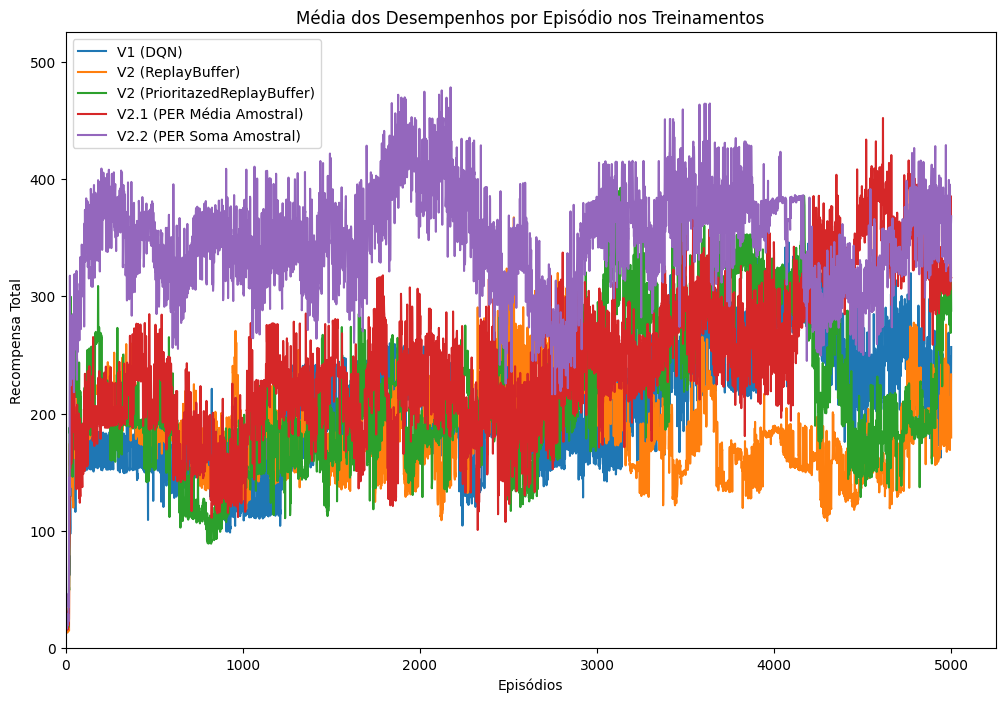

In [ ]:
plotar_versoes(    coluna = 'Rewards_ep',
                   xlabel = 'Episódios',
                   ylabel = 'Recompensa Total',
                   tamanho_fig = (12, 8),
                   limit = True,
                   xlimit = episodios,
                   ylimit = 500,
                   title = 'Média dos Desempenhos por Episódio nos Treinamentos')

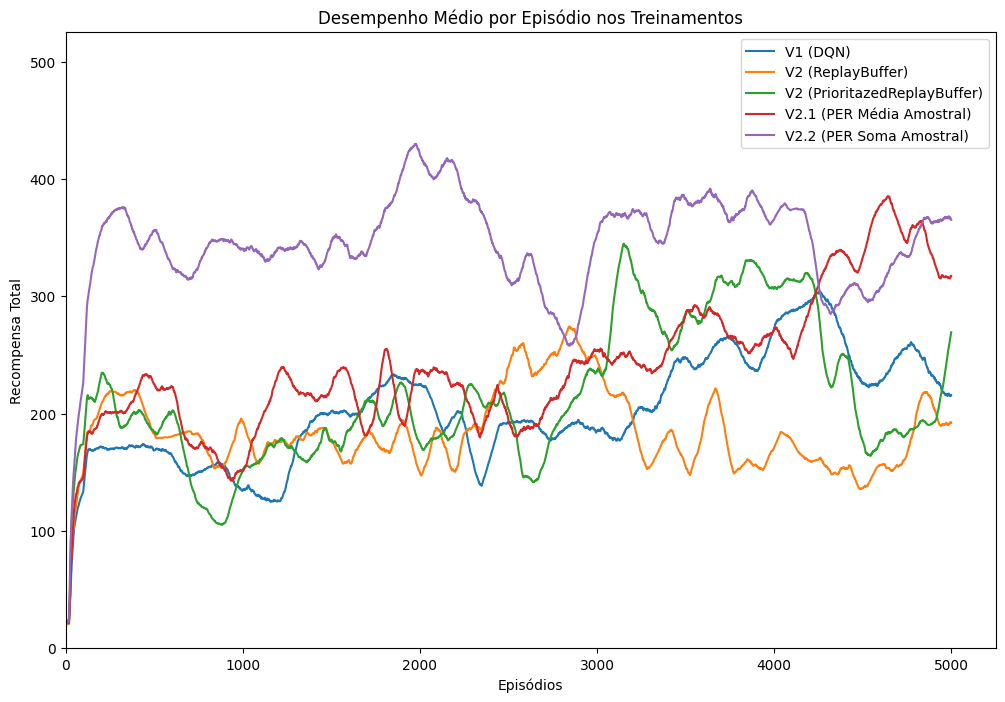

In [ ]:
plotar_versoes(    coluna = 'Rewards_mean_ep',
                   xlabel = 'Episódios',
                   ylabel = 'Recompensa Total',
                   tamanho_fig = (12, 8),
                   limit = True,
                   xlimit = episodios,
                   ylimit = 500,
                   title = 'Desempenho Médio por Episódio nos Treinamentos')

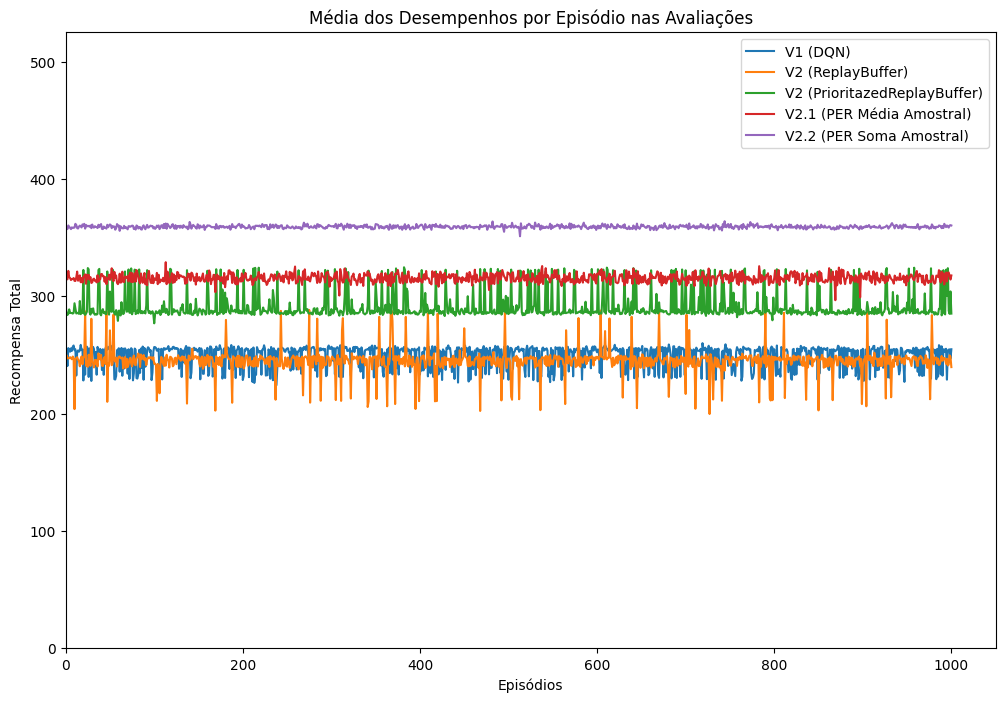

In [ ]:
plotar_versoes(    coluna = 'Rewards_ep_eval',
                   xlabel = 'Episódios',
                   ylabel = 'Recompensa Total',
                   tamanho_fig = (12, 8),
                   limit = True,
                   xlimit = 1000,
                   ylimit = 500,
                   title = 'Média dos Desempenhos por Episódio nas Avaliações')

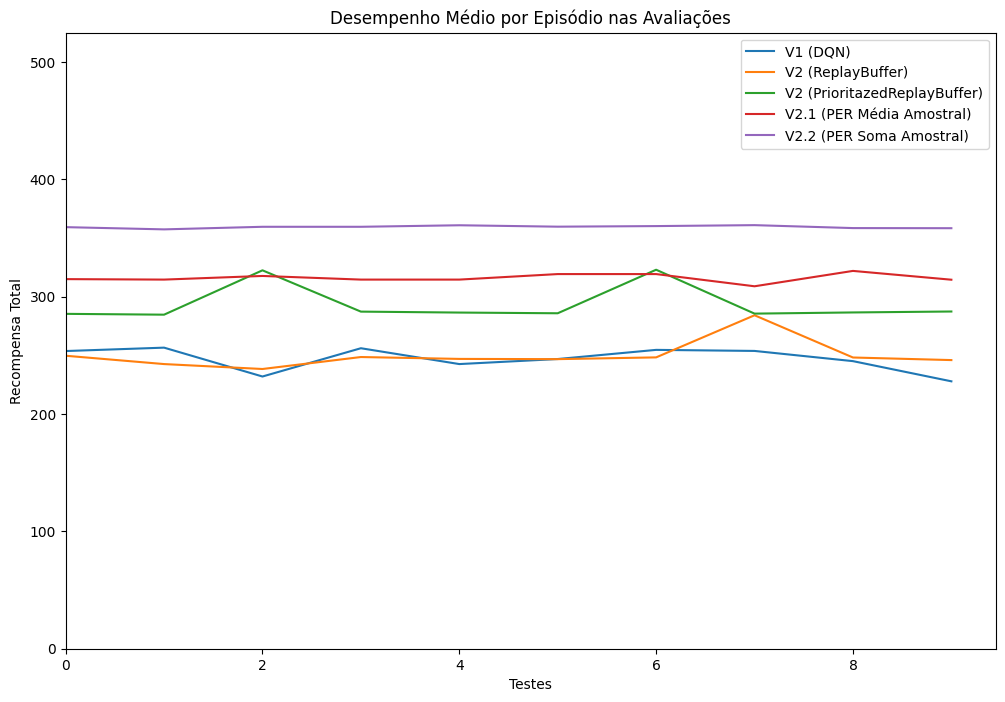

In [ ]:
plotar_versoes(    coluna = 'Rewards_mean_ep_eval',
                   xlabel = 'Testes',
                   ylabel = 'Recompensa Total',
                   tamanho_fig = (12, 8),
                   limit = True,
                   xlimit = 9,
                   ylimit = 500,
                   title = 'Desempenho Médio por Episódio nas Avaliações')

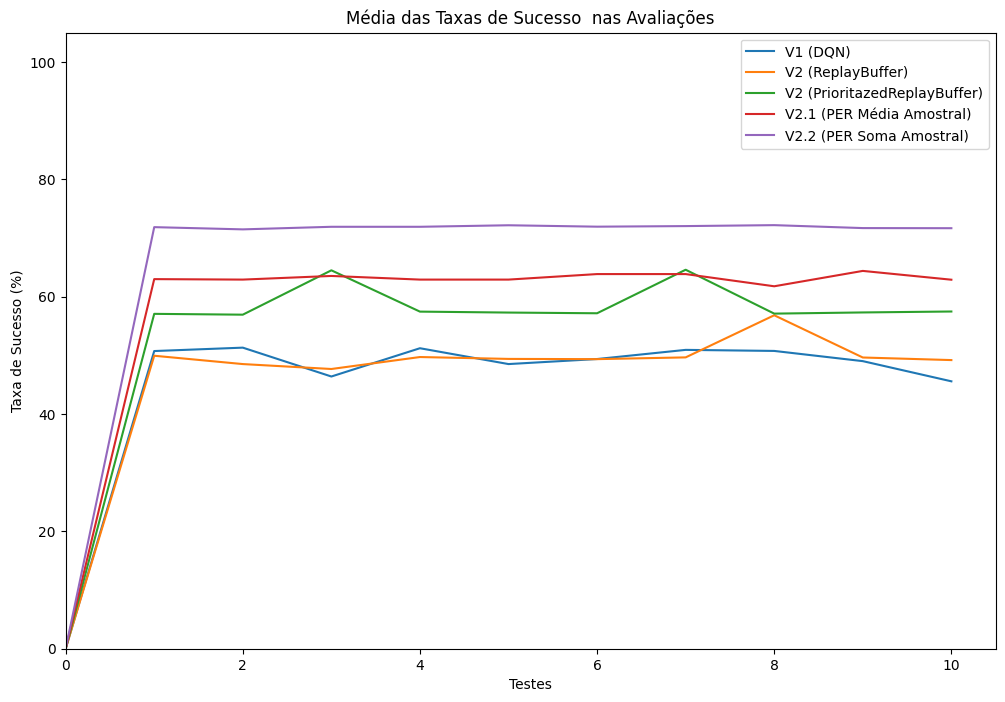

In [ ]:
plotar_versoes(    coluna = 'Sucess_Rates',
                   xlabel = 'Testes',
                   ylabel = 'Taxa de Sucesso (%)',
                   tamanho_fig = (12, 8),
                   limit = True,
                   xlimit = 10,
                   ylimit = 100,
                   title = 'Média das Taxas de Sucesso  nas Avaliações')

## Carrega e Exibe Resultados

In [ ]:
resultado_1_V4_2 = carrega_array("C1",
                  "V4.2",
                  numero_simulacao = 1,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)
resultado_1_V4_2.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Rewards_ep,Rewards_mean_ep,Rewards_ep_eval,Rewards_mean_ep_eval,Sucess_Rates,Mean_Rewards_ep_eval,Mean_Sucess_Rates
0,26,26.0,105.0,106.0,0.0,105.8,21.2
1,24,25.0,106.0,102.0,21.2,NaN,NaN
2,28,26.0,102.0,102.0,20.4,NaN,NaN
3,24,25.5,108.0,106.0,20.4,NaN,NaN
4,18,24.0,108.0,106.0,21.2,NaN,NaN


In [ ]:
resultado = carrega_varios("C1",
                           "V4.2",
                           inicio = 1,
                           fim = 1,
                           caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                           pasta = nome_pasta)
resultado[0].head()

,Rewards_ep,Rewards_mean_ep,Rewards_ep_eval,Rewards_mean_ep_eval,Sucess_Rates,Mean_Rewards_ep_eval,Mean_Sucess_Rates
0,26,26.0,105.0,106.0,0.0,105.8,21.2
1,24,25.0,106.0,102.0,21.2,NaN,NaN
2,28,26.0,102.0,102.0,20.4,NaN,NaN
3,24,25.5,108.0,106.0,20.4,NaN,NaN
4,18,24.0,108.0,106.0,21.2,NaN,NaN


In [ ]:
resultado_medio_V4_2 = resultado_medio(resultado)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


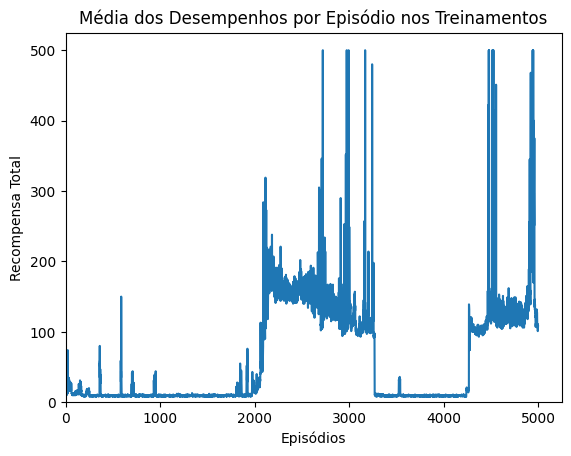

In [ ]:
plotar(resultado_medio_V4_2['Rewards_ep'],
       xlabel = 'Episódios',
       ylabel = 'Recompensa Total',
       limit = True,
       xlimit = episodios,
       ylimit = 500,
       title = 'Média dos Desempenhos por Episódio nos Treinamentos')

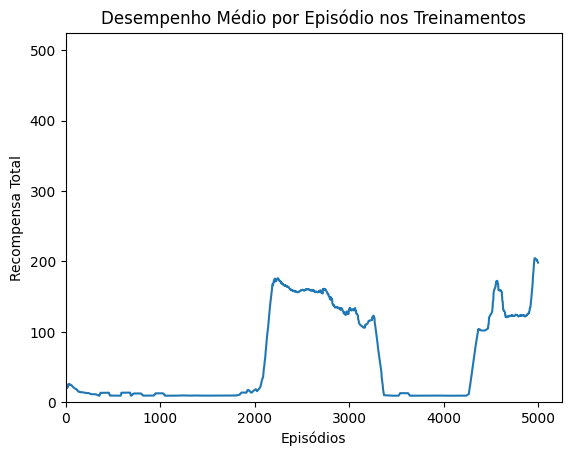

In [ ]:
plotar(resultado_medio_V4_2['Rewards_mean_ep'],
       xlabel = 'Episódios',
       ylabel = 'Recompensa Total',
       limit = True,
       xlimit = episodios,
       ylimit = 500,
       title = 'Desempenho Médio por Episódio nos Treinamentos')

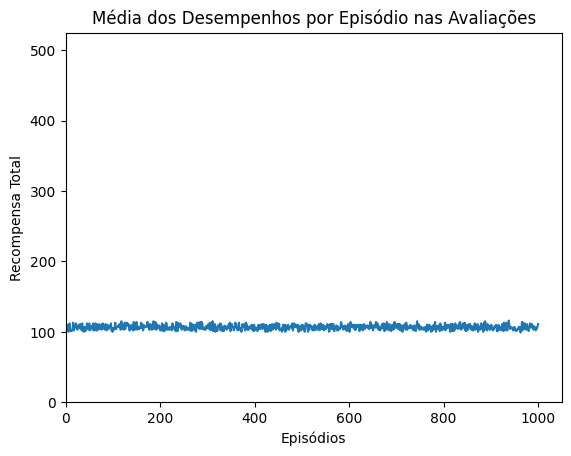

In [ ]:
plotar(resultado_medio_V4_2['Rewards_ep_eval'],
       xlabel = 'Episódios',
       ylabel = 'Recompensa Total',
       limit = True,
       xlimit = 1000,
       ylimit = 500,
       title = 'Média dos Desempenhos por Episódio nas Avaliações')

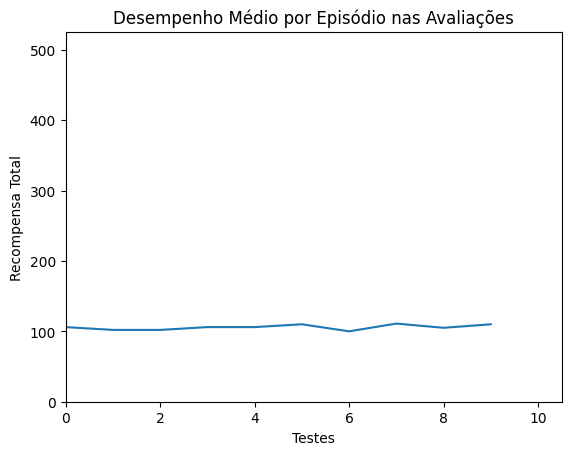

In [ ]:
plotar(resultado_medio_V4_2['Rewards_mean_ep_eval'],
       xlabel = 'Testes',
       ylabel = 'Recompensa Total',
       limit = True,
       xlimit = 10,
       ylimit = 500,
       title = 'Desempenho Médio por Episódio nas Avaliações')

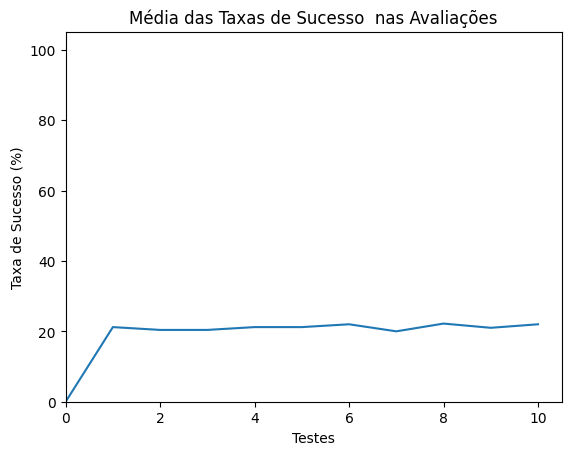

In [ ]:
plotar(resultado_medio_V4_2['Sucess_Rates'],
       xlabel = 'Testes',
       ylabel = 'Taxa de Sucesso (%)',
       limit = True,
       xlimit = 10,
       ylimit = 100,
       title = 'Média das Taxas de Sucesso  nas Avaliações')

## Carrega e Exibe Resultados

In [ ]:
resultado_1_V4_3 = carrega_array("C1",
                  "V4.3",
                  numero_simulacao = 1,
                  caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                  pasta = nome_pasta)
resultado_1_V4_3.head()

In [ ]:
resultado = carrega_varios("C1",
                           "V4.3",
                           inicio = 1,
                           fim = 1,
                           caminho = '/content/drive/My Drive/CBA 2024/Resultados/',
                           pasta = nome_pasta)
resultado[0].head()

In [ ]:
resultado_medio_V4_3 = resultado_medio(resultado)

In [ ]:
plotar(resultado_medio_V4_3['Rewards_ep'],
       xlabel = 'Episódios',
       ylabel = 'Recompensa Total',
       limit = True,
       xlimit = episodios,
       ylimit = 500,
       title = 'Média dos Desempenhos por Episódio nos Treinamentos')

In [ ]:
plotar(resultado_medio_V4_3['Rewards_mean_ep'],
       xlabel = 'Episódios',
       ylabel = 'Recompensa Total',
       limit = True,
       xlimit = episodios,
       ylimit = 500,
       title = 'Desempenho Médio por Episódio nos Treinamentos')

In [ ]:
plotar(resultado_medio_V4_3['Rewards_ep_eval'],
       xlabel = 'Episódios',
       ylabel = 'Recompensa Total',
       limit = True,
       xlimit = 1000,
       ylimit = 500,
       title = 'Média dos Desempenhos por Episódio nas Avaliações')

In [ ]:
plotar(resultado_medio_V4_3['Rewards_mean_ep_eval'],
       xlabel = 'Testes',
       ylabel = 'Recompensa Total',
       limit = True,
       xlimit = 10,
       ylimit = 500,
       title = 'Desempenho Médio por Episódio nas Avaliações')

In [ ]:
plotar(resultado_medio_V4_3['Sucess_Rates'],
       xlabel = 'Testes',
       ylabel = 'Taxa de Sucesso (%)',
       limit = True,
       xlimit = 10,
       ylimit = 100,
       title = 'Média das Taxas de Sucesso  nas Avaliações')